In [4]:
# Remember to use python 3.10 for now (scikit-network currently cannot be installed properly)

from bw_temporalis import easy_timedelta_distribution, TemporalisLCA
import bw2data as bd
import bw2calc as bc
import seaborn as sb
from bw_temporalis import easy_timedelta_distribution, TemporalisLCA
from bw_temporalis.lcia import characterize_co2

In [5]:
bd.projects.set_current("bw_temporalis example")

In [6]:
MILAGE = 200_000  # Assume car is driven 200.000 km
LIFETIME = 15     # 15 years

bd.Database('example').write({
    ('example', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "unit": "kilogram",
    },
    ('example', 'petrol-car'): {
        'name': 'Drive a petrol car',
        'exchanges': [
            {
                'amount': 1,
                'type': 'technosphere',
                'input': ('example', 'car-manufacture'),
                # Not sure when car and its materials were manufactured, 
                # we therefore allocate burden over four years prior to purchase
                'temporal_distribution': easy_timedelta_distribution(
                    start=-36,
                    end=-4,
                    resolution="M",  # M for months, Y for years, etc.
                    steps=10,
                    kind="triangular",
                    param=-24,
                ),
            },

            # Petrol car - produce the petrol
            {
                'amount': MILAGE,
                'type': 'technosphere',
                'input': ('example', 'produce-petrol'),

                # Recurring inventory : goes from 0 to lifetime (no uncertainty distribution to pick from)
                'temporal_distribution': easy_timedelta_distribution(
                    start=0,
                    end=LIFETIME,
                    resolution="Y",
                    steps=LIFETIME + 1,  # Includes both start and end
                ),
            },

            # Petrol car - drive the car
            {
                'amount': MILAGE,
                'type': 'technosphere',
                'input': ('example', 'drive-petrol'),
                'temporal_distribution': easy_timedelta_distribution(
                    start=0,
                    end=LIFETIME,
                    resolution="Y",
                    steps=LIFETIME + 1,
                ),
            },
        ],
    },
    ('example', 'car-manufacture'): {
        'name': 'Manufacture a combustion car',
        'exchanges': [
            {
                'amount': 11600,
                'input': ('example', "CO2"),
                'type': 'biosphere'
            },
        ]
    },
    ('example', 'drive-petrol'): {
        'name': 'Drive a petrol car over one kilometer',
        'exchanges': [
            {
                # Motive energy
                'amount': 0.153,  # kg CO2 / km
                'input': ('example', "CO2"),
                'type': 'biosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=0,
                    end=11,
                    resolution="M",
                    steps=4, 
                ),
            },
        ]
    },
    ('example', 'produce-petrol'): {
        'name': 'Extract, refine, and transport petrol for one kilometer driving',
        'exchanges': [
            {
                'amount': 0.028,  # kg CO2 / km
                'input': ('example', "CO2"),
                'type': 'biosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=-2,
                    end=9,
                    resolution="M",
                    steps=4, 
                ),
            },
        ]
    },
    ('example', 'bioethanol-car'): {
        'name': 'Drive a bioethanol car',
        'exchanges': [
            {
                # Same as petrol car
                'amount': 1,
                'type': 'technosphere',
                'input': ('example', 'car-manufacture'),
                'temporal_distribution': easy_timedelta_distribution(
                    start=-36,
                    end=-4,
                    resolution="M",
                    steps=10,
                    kind="triangular",
                    param=-24,
                ),
            },
            {
                'amount': MILAGE,
                'type': 'technosphere',
                'input': ('example', 'produce-bioethanol'),
                'temporal_distribution': easy_timedelta_distribution(
                    start=0,
                    end=LIFETIME,
                    resolution="Y",
                    steps=LIFETIME + 1,  # Includes both start and end
                ),
            },
            {
                'amount': MILAGE,
                'type': 'technosphere',
                'input': ('example', 'drive-bioethanol'),
                'temporal_distribution': easy_timedelta_distribution(
                    start=0,
                    end=LIFETIME,
                    resolution="Y",
                    steps=LIFETIME + 1,
                ),
            },
        ],
    },
    ('example', 'drive-bioethanol'): {
        'name': 'Drive a bioethanol car over one kilometer',
        'exchanges': [
            {
                'amount': 0.152,  # total fossil and biogenic kg CO2 / km 
                'input': ('example', "CO2"),
                'type': 'biosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=0,
                    end=11,
                    resolution="M",
                    steps=4, 
                ),
            },
        ]
    },
    ('example', 'produce-bioethanol'): {
        'name': 'Grow, refine, and transport bioethanol for one kilometer driving',
        'exchanges': [
            {
                # kg CO2 / km; 0.042 is refining of biomass, 
                # -0.15 is carbon capture by plants
                'amount': 0.042 - 0.15,  
                'input': ('example', "CO2"),
                'type': 'biosphere',
                'temporal_distribution': easy_timedelta_distribution(
                    start=-12,
                    end=-3,
                    resolution="M",
                    steps=5, 
                ),
            },
        ]
    },
    ('example', 'electric-car'): {
        'name': 'Drive an electric car',
        'exchanges': [
            {
                'amount': 1,
                'type': 'technosphere',
                'input': ('example', 'electric-car-manufacture'),
                'temporal_distribution': easy_timedelta_distribution(
                    start=-24,
                    end=-1,
                    resolution="M",
                    steps=12,
                    kind="triangular",
                    param=-12,
                ),
            },
            {
                'amount': MILAGE,
                'type': 'technosphere',
                'input': ('example', 'produce-electricity'),
                'temporal_distribution': easy_timedelta_distribution(
                    start=0,
                    end=LIFETIME * 12,
                    resolution="M",
                    steps=LIFETIME * 48 + 1,  # Includes both start and end
                ),
            },
        ],
    },
    ('example', 'electric-car-manufacture'): {
        'name': 'Manufacture an electric car',
        'exchanges': [
            {
                'amount': 18000,  # CO2 to produce electric car including battery
                'input': ('example', "CO2"),
                'type': 'biosphere'
            },
        ]
    },
    ('example', 'produce-electricity'): {
        'name': 'Generate electricity needed for one kilometer',
        'exchanges': [
            {
                'amount': 0.08,
                'input': ('example', "CO2"),
                'type': 'biosphere',
            },
        ]
    },
})

C:\Users\xtang\anaconda3\envs\bw_autumn23\lib\site-packages\bw_temporalis\utils.py:194: UserWarning: More steps than discrete possibilities (721 versus 181).
    Values will be duplicated due to rounding.
  warnings.warn(MESSAGE)


Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11003.42it/s]


Vacuuming database 


In [7]:
bd.Method(("GWP", "example")).write([
    (('example', "CO2"), 1),
])

In [8]:
lca = bc.LCA({('example', 'petrol-car'): 1}, ("GWP", "example"))
lca.lci()
lca.lcia()

In [9]:
lca.score

47799.99960064888

In [10]:
tlca = TemporalisLCA(lca)

Starting graph traversal
Calculation count: 3


In [11]:
tl = tlca.build_timeline()
df = tl.build_dataframe()

Text(0.5, 0, 'Time (years)')

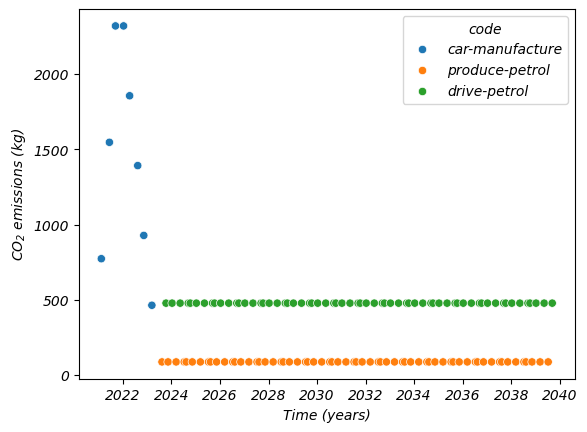

In [12]:
axes = sb.scatterplot(
    x="date", 
    y="amount",
    hue="code",
    data=df.merge(
        bd.Database('example').nodes_to_dataframe().rename(columns={'id': 'activity'}), 
        on='activity'
    )
)
axes.set_ylabel("$CO_{2}$ emissions (kg)")
axes.set_xlabel("Time (years)")

Text(0.5, 0, 'Time (years)')

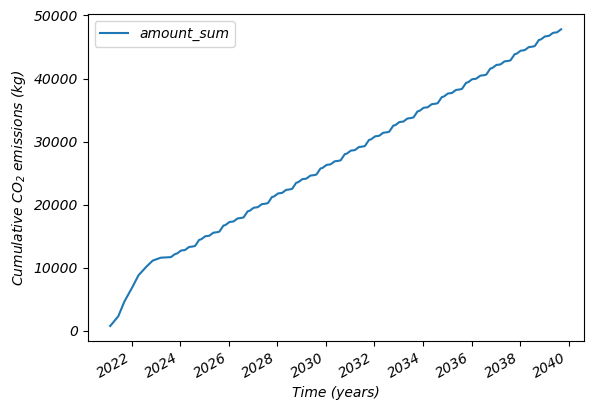

In [13]:
df["amount_sum"] = df['amount'].cumsum()
axes = df.plot(x="date", y="amount_sum")
axes.set_ylabel("Cumulative $CO_{2}$ emissions (kg)")
axes.set_xlabel("Time (years)")

In [14]:
characterized_df = tl.characterize_dataframe(
    characterization_function=characterize_co2, 
    flow={bd.get_node(name="carbon dioxide").id},
    cumsum=True
)
characterized_df = characterized_df[characterized_df['amount'] > 0]

Text(0.5, 0, 'Time (years)')

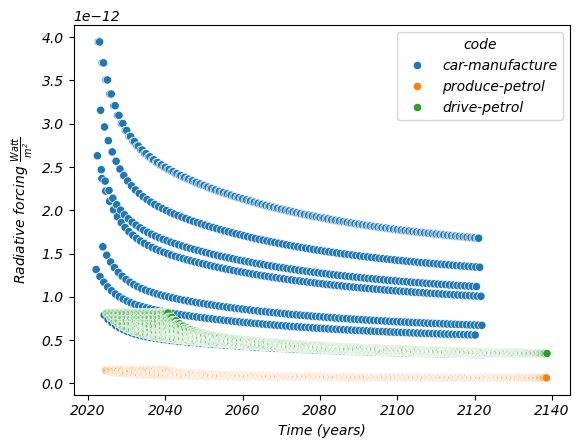

In [15]:
axes = sb.scatterplot(
    x="date", 
    y="amount",
    hue="code",
    data=characterized_df.merge(
        bd.Database('example').nodes_to_dataframe().rename(columns={'id': 'activity'}), 
        on='activity'
    )
)
axes.set_ylabel("Radiative forcing $\\frac{Watt}{m^{2}}$")
axes.set_xlabel("Time (years)")

In [16]:
def df_for_func_unit(func_unit):
    lca = bc.LCA(func_unit, ("GWP", "example"))
    lca.lci()
    lca.lcia()
    tlca = TemporalisLCA(lca)
    tl = tlca.build_timeline()
    df = tl.build_dataframe()
    df["amount_sum"] = df['amount'].cumsum()
    return df

Starting graph traversal
Calculation count: 2
Starting graph traversal
Calculation count: 3


Text(0.5, 1.0, 'Example life-cycle $CO_{2}$ emissions for a 2023 car')

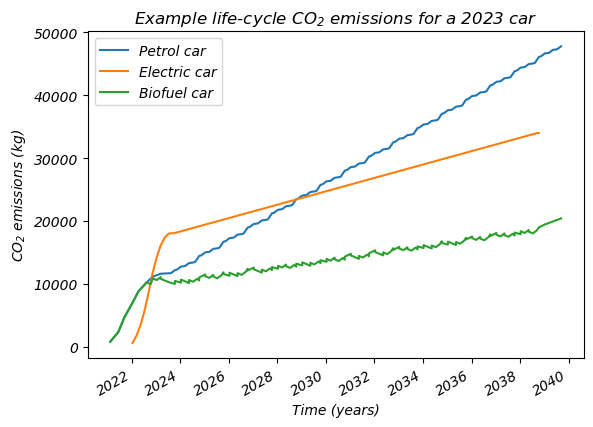

In [17]:
df['Petrol car'] = df['amount_sum']
axes = df.plot(x="date", y="Petrol car")

df2 = df_for_func_unit({('example', 'electric-car'): 1})
df2['Electric car'] = df2['amount_sum']
df2.plot(x="date", y="Electric car", ax=axes)

df3 = df_for_func_unit({('example', 'bioethanol-car'): 1})
df3['Biofuel car'] = df3['amount_sum']
df3.plot(x="date", y='Biofuel car', ax=axes)

axes.set_ylabel("$CO_{2}$ emissions (kg)")
axes.set_xlabel("Time (years)")
axes.set_title("Example life-cycle $CO_{2}$ emissions for a 2023 car")

In [18]:
def characterized_df_for_func_unit(func_unit):
    lca = bc.LCA(func_unit, ("GWP", "example"))
    lca.lci()
    lca.lcia()
    tlca = TemporalisLCA(lca)
    tl = tlca.build_timeline()
    df = tl.build_dataframe()
    characterized_df = tl.characterize_dataframe(
        characterization_function=characterize_co2, 
        flow={bd.get_node(name="carbon dioxide").id},
        cumsum=False
    )
    characterized_df = characterized_df[characterized_df['amount'] > 0]
    characterized_df["amount_sum"] = characterized_df["amount"].cumsum()
    return characterized_df

Starting graph traversal
Calculation count: 2
Starting graph traversal
Calculation count: 3


Text(0.5, 0, 'Time (years)')

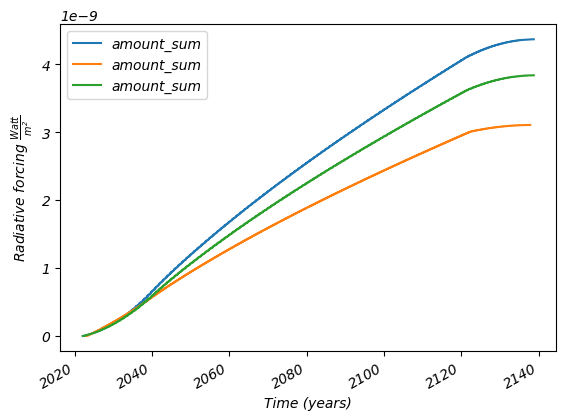

In [19]:
axes = characterized_df.plot(x="date", y="amount_sum")
characterized_df_for_func_unit({('example', 'electric-car'): 1}).plot(x="date", y="amount_sum", ax=axes)
characterized_df_for_func_unit({('example', 'bioethanol-car'): 1}).plot(x="date", y="amount_sum", ax=axes)

axes.set_ylabel("Radiative forcing $\\frac{Watt}{m^{2}}$")
axes.set_xlabel("Time (years)")

In [2]:
print('End of tutorial.')

End of tutorial.
